<a href="https://colab.research.google.com/github/YIBoX-memorial/ComputationalNeuroscience/blob/master/TNC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theoretical Neuroscience Chapter 2 Exercise

The exercise contains 6 problems.

In [1]:
import scipy.io
# mat = scipy.io.loadmat('c1p8.mat')
from math import exp
from math import log
from math import cos
from math import sin
from math import pi
from math import ceil
from math import sqrt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
# import cupy as cp
import matplotlib.pyplot as plt
! nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
class CST:
    __delta__ = 0.002 # s
    __GPU = False
    __default__ = 0.002
    def __init(self):
        pass
    @classmethod
    def delta(cls):
        return cls.__delta__
    @classmethod
    def GPU(cls):
        return cls.__GPU
    def set_delta(cls, x):
        cls.__default__ = cls.__delta__
        cls.__delta__ = x
    def reset_delta(cls):
        cls.__delta__ =  cls.__default__

def pos(x):
    return int(x / CST.delta())

def s2ms(x):
    return 1000*x

def ms2s(x):
    return x/1000.0

# CST.set_delta(CST, 0.1)
# print(CST.delta())
# CST.reset_delta(CST)
# print(CST.delta())

# Function

Definition of functions.

In [3]:
class Func:
    def __init__(self, *args, **kwargs):
        pass
    def value(self, x:float=0.0, *args, **kwargs):
        pass
    def __call__(self, input, *args, **kwargs):
        '''
        if isinstance(input, np.ndarray):
            ret = np.zeros(input.size)
            for (index, value) in enumerate(input):
                ret[index] = self.value(value)
            return ret
        '''
        return self.value(input)

class Const(Func):
    def __init__(self, value:float=0.0, *args, **kwargs):
        self.__value = value
    def value(self, x:float=0.0, *args, **kwargs):
        return self.__value

class Refractory_Func(Func):
    def __init__(self, r0:float=0.0, ref_period:float=1.0, *args, **kwargs):
        self.__r0 = r0
        self.__ref_period = ref_period
    def value(self, x:float=0.0, *args, **kwargs):
        try:
            return self.__r0 * ( 1 - exp(-x/self.__ref_period) )
        except:
            print('x: ', x)



# Spikes

This cell contains definition of sipkes and correlations.

In [4]:
class SpikeS:
    def __init__(self, low:float=0.0, high:float=1.0, events=np.zeros(1), *args, **kwargs):
        self.__low = low
        self.__high = high
        if CST.GPU() and isinstance(events, np.ndarray):
            self.__events = cp.asarray(events)
        else:
            self.__events = events
    def get_bound(self):
        return (self.__low, self.__high)
    def get_size(self):
        return self.__events.size
    def firing_rate(self, time:float=0.0):
        if time < self.__low or time > self.__high:
            raise IndexError("Error Index for time!")
        x = pos(time - self.__low)
        return self.__events[x]
    def firing_rate(self, low:float=0.0, high:float=-1.0):
        if high < low:
            high = self.__high
        l = pos(low - self.__low)
        h = pos(high - self.__low)
        if low < self.__low or low > self.__high:
            raise IndexError("Error Index for low!")
        if high < self.__low or high > self.__high:
            raise IndexError("Error Index for high!")
        if l > h:
            raise IndexError("l > h !!!")
        return self.__events[l:h]
    def mean(self, low:float=0.0, high:float=-1.0, *args, **kwargs):
        if high < low:
            high = self.__high
        l = pos(low - self.__low)
        h = pos(high - self.__low)
        return self.__events[l:h].mean()
    def pure(self, low:float=0.0, high:float=-1.0, *args, **kwargs):
        if high < low:
            high = self.__high
        l = pos(low - self.__low)
        h = pos(high - self.__low)
        if CST.GPU():
            ret = cp.subtract( self.__events[l:h], self.__events[l:h].mean() )
        else:
            ret = np.subtract( self.__events[l:h], self.__events[l:h].mean() )
        return SpikeS(low, high, ret)
    def count_dis(self, assigned:int=-1, *args, **kwargs):
        ret = np.zeros( pos(self.__high - self.__low) )
        last_index = -1
        max_interval = 0
        events = self.__events
        if CST.GPU() and isinstance(events, cp.ndarray):
            events = cp.asnumpy(events)
        for (index, value) in enumerate(events):
            if value == 1.0:
                ret[index - last_index] = ret[index - last_index] + 1
                # print(index - last_index)
                max_interval = max(max_interval, index - last_index)
                last_index = index
        if assigned != -1:
            max_interval = assigned
        else:
            max_interval = max_interval + 1
        return ret[:max_interval]
    def print(self, *args, **kwargs):
        print('SpikeS: \n')
        print('\tlow:', self.__low, 'high: ', self.__high, '\nevents: ', self.__events)


# spike 1, spike 2, difference
def correlation(s1, s2, d):
    (s1_l, s1_h) = s1.get_bound()
    s1 = s1.firing_rate(s1_l, s1_h)
    (s2_l, s2_h) = s2.get_bound()
    s2 = s2.firing_rate(s2_l, s2_h)
    d = ( (pos(d) % s2.size) + s2.size) % s2.size
    times = ceil((s1_h-s1_l) / (s2_h-s2_l)) + 2
    ret = 0.0
    if CST.GPU():
        if isinstance(s1, np.ndarray):
            s1 = cp.asarray(s1)
        if isinstance(s2, np.ndarray):
            s2 = cp.asarray(s2)
        s2 = cp.tile(s2, times)
        ret = cp.sum( cp.multiply(s1, s2[d:d+s1.size]) )
    else:
        s2 = np.tile(s2, times)
        ret = np.sum( np.multiply(s1, s2[d:d+s1.size]) )
    ret = ret / (CST.delta()*s1.size)
    return ret

def distance(s1, s2):
    (s1_l, s1_h) = s1.get_bound()
    s1 = s1.firing_rate(s1_l, s1_h)
    (s2_l, s2_h) = s2.get_bound()
    s2 = s2.firing_rate(s2_l, s2_h)
    if s1_l != s2_l or s1_h != s2_h:
        raise IndexError('Inequal sequences!')
    if CST.GPU():
        if isinstance(s1, np.ndarray):
            s1 = cp.asarray(s1)
        if isinstance(s2, np.ndarray):
            s2 = cp.asarray(s2)
        ret = cp.sum( cp.multiply(s1-s2, s1-s2) )
    else:
        ret = np.sum( np.multiply(s1-s2, s1-s2) )
    return ret

# Prototype of generators

In [5]:
class Generator:
    __valid_types = ['normal', 'Poisson', 'uniform', 'func']
    def __init__(self, dtype:str='None', *args, **kwargs):
        flag = False
        if type != 'None':
            for type_i in self.__valid_types:
                if type_i == type_i:
                    flag = True
                    break
        if flag == False:
            raise TypeError("Invalid Distribution Types!")
    def output(self, *args, **kwargs):
        pass


# Poisson Generators

In [6]:
# Poisson Generator generates interval length between 2 events
class Poisson_Generator(Generator):
    def __init__(self, dtype:str='Poisson', rate:float=1.0, rmap=None, *args, **kwargs):
        super().__init__(dtype)
        self.__rate = rate
        if rmap == None:
            rmap = Const(value=rate)
        self.__rmap = rmap
    def reset(self, rate:float=1.0, rmap=None, *args, **kwargs):
        self.__rate = rate
        if rmap != None:
            self.__rmap = rmap
    # here, next function generates the next spike time
    def next(self, *args, **kwargs) -> float:
        return -log(np.random.uniform(low=0.0, high=1.0))/self.__rate
    def thin(self, x:float=0.0, rate=Const(), *args, **kwargs) -> bool:
        if np.random.uniform(low=0.0, high=1.0) < rate(x)/self.__rate:
            return True
        return False
    def output(self, low:float=0.0, high:float=10.0, *args, **kwargs):
        s = np.zeros(shape=pos(high-low), dtype=float)
        # high = high - CST.delta()
        current = low
        while current < high:
            # print('next: ', self.next())
            current = current + self.next()
            if current > high:
                break
            s[pos(current - low)] = 1.0
        for (index, value) in enumerate(s):
            if value == 1.0:
                if self.thin(x=index*CST.delta()-low, rate=self.__rmap) == False:
                    s[index] = 0.0
        ret = SpikeS(low, high, s)
        return ret

class Refractory_Generator(Generator):
    def __init__(self, dtype:str='Poisson', rate:float=1.0, rmap=None, ref:bool=True, *args, **kwargs):
        super().__init__(dtype)
        self.__rate = rate
        if rmap == None:
            rmap = Const(value=rate)
        self.__rmap = rmap
        self.__last_spike = -100.0
        self.__ref = ref
    def reset(self, rate:float=-1.0, rmap=None, ref:bool=True, *args, **kwargs):
        if rmap != None:
            self.__rmap = rmap
        if rate >= 0:
            self.__rate = rate
        self.__last_spike = -100.0
        self.__ref = ref
    # here, value function generates the potential of next interval
    def value(self, time:float=0.0, *args, **kwargs):
        if np.random.uniform(low=0.0, high=1.0) < self.__rmap(time) * CST.delta():
            return 1.0
        return 0.0
    def output(self, low:float=0.0, high:float=1.0, *args, **kwargs):
        s = np.zeros(shape=pos(high-low), dtype=float)
        high = high - CST.delta()
        for current in np.arange(low, high, CST.delta()):
            s[ pos(current - low) ] = self.value(current - self.__last_spike)
            # print('current: ', current, 'last: ', self.__last_spike, 'value: ', self.value(current - self.__last_spike)*CST.delta())
            if self.__ref == True and s[ pos(current - low) ] > 0:
                self.__last_spike = current
        ret = SpikeS(low, high, s)
        return ret


# Normal Generator



In [7]:
class Normal_Generator(Generator):
    def __init__(self, dtype:str='normal', mean:float=0.0, deviation:float=1.0, *args, **kwargs):
        super().__init__(dtype)
        self.__mean=mean
        self.__deviation=deviation
    def value(self, *args, **kwargs):
        # print(self.__mean, self.__deviation, args)
        return np.random.normal(self.__mean, self.__deviation, args)
    def output(self, low:float=0.0, high:float=1.0, *args, **kwargs):
        s = np.random.normal(self.__mean, self.__deviation, pos(high-low))
        ret = SpikeS(low, high, s)
        return ret


# Func Generator

In [8]:
class Func_Generator(Generator):
    def __init__(self, dtype:str='func', rmap=Const(0.5), *args, **kwargs):
        super().__init__()
        self.__rmap = rmap
    def value(self, x, *args, **kwargs):
        return self.__rmap(x)
    def output(self, low:float=0.0, high:float=1.0, *args, **kwargs):
        s = np.zeros(shape=pos(high-low), dtype=float)
        for current in np.arange(low, high, CST.delta()):
            s[ pos(current-low) ] = self.value(current)
        ret = SpikeS(low, high, s)
        return ret

# Problem 1

Use the rate given by equation \\(r_\text{est}(t)=r_0+\int_0^\infty\ d\tau\ D(\tau)s(t-\tau)\\) with \\(r_0=50\text{Hz}\\) and

\\(D(\tau)=-\cos\left(\frac{2\pi(\tau-20\text{ms})}{140\text{ms}}\right)\exp\left(-\frac{\tau}{60\text{ms}}\right)\text{Hz/ms}\\)

to predict the response of a neuron of the electrosensory lateral-line lobe to a stimulus. The above equation is an approximation for the linear kernel obtained from the spike-triggered average shown in figure 1.9. Use an approximate Gaussian white noise stimulus constructed by choosing a stimulus value every \\(10\text{ms}(t=10\text{ms})\\) from a Gaussian distribution with zero mean and variance \\(\sigma^2_s=t\\), with \\(\sigma^2_s=10\\). Compute the firing rate over a \\(10\ \text{s}\\) period.
From the results, compute the firing rate-stimulus correlation function \\(Q_{rs}(\tau)\\). Using equation \\(D(\tau)=\frac{Q_{rs}(-\tau)}{\sigma^2_s}\\), compare \\(Q_{rs}(-\tau)/\sigma^2_s\\) with the kernel \\(D(\tau)\\) given above.



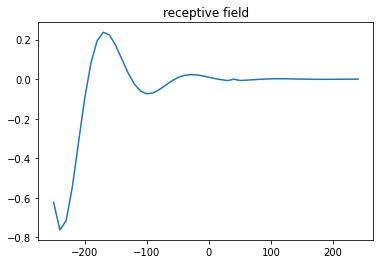

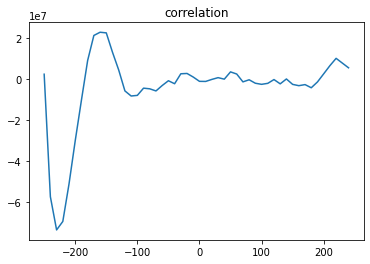

In [ ]:
class rec1(Func):
    def __init__(self):
        super().__init__()
    def value(self, x:float=0.0):
        return -cos(2*pi*(s2ms(x)-20)/140)*exp(-s2ms(x)/60)
class P1:
    def __init__(self):
        self.__TL = 0.0
        self.__TH = 10.0
        self.__gen = Normal_Generator(mean=0.0, deviation=10/CST.delta())
        self.__rec = Func_Generator(rmap=rec1())
        self.__total_steps = 50
    def __sl(self):
        return -self.__total_steps*s2ms(CST.delta())/2
    def __sh(self):
        return self.__total_steps*s2ms(CST.delta())/2
    def __process(self):
        sq1 = self.__gen.output(self.__TL, self.__TH)
        sq2 = self.__rec.output(self.__TL, self.__TH)
        fr = np.zeros(pos(self.__TH-self.__TL), dtype=float)
        for current in np.arange(self.__TL, self.__TH, step=CST.delta()):
            fr[pos(current)] = np.sum( np.multiply( np.flip(sq1.firing_rate(low=self.__TL, high=current)), sq2.firing_rate(low=self.__TL, high=current) ) )
        fr = SpikeS(self.__TL, self.__TH, fr)
        cor = np.zeros(self.__total_steps, dtype=float)
        for dist in np.arange(self.__total_steps*CST.delta(), step=CST.delta()):
            cor[pos(dist)] = correlation(sq1, fr, dist)
        return (sq2.firing_rate(), cor)
    def __plot(self, sq, title:str='', *args, **kwargs):
        if CST.GPU():
            if isinstance(sq, cp.ndarray):
                sq = cp.asnumpy(sq)
        plt.plot( np.arange(self.__sl(), self.__sh(), step=s2ms(CST.delta())), sq[0:self.__total_steps])
        plt.title(title)
        plt.show()
    def __call__(self):
        sq = self.__process()
        self.__plot(sq[0], title='receptive field')
        self.__plot(sq[1], title='correlation')

CST.set_delta(CST, 0.01)
W1 = P1()
W1()
CST.reset_delta(CST)

# Problem 2

matlab® file 1p8.mat contains the data described in exercise 8 of chapter 1.

Use the spike-triggered average (calculated in that exercise) to construct a linear kernel and use it in equation \\(r_\text{est}(t)=r_0+\int_0^\infty\ d\tau\ D(\tau)s(t-\tau)\\) to provide a model of the response of the H1 neuron.

Choose \\(r_0\\) so that the average firing rate predicted by the model in response to the stimulus used for the data matches the actual average firing rate. Use a Poisson generator with the computed rate to generate a synthetic spike train from this linear estimate of the firing rate in response to the stimulus stim. Plot examples of the actual and synthetic spike trains. How are they similar and how do they differ?

Plot the autocorrelation function of the actual and the synthetic spike trains over the range \\(0\\) to \\(100\text{ms}\\). Why is there a dip at a lag of \\(2\text{ms}\\) in the autocorrelation of the actual spike train? Is there a dip for the synthetic train too? Plot the interspike interval histogram for both spike trains. Why is there a dip below 6 ms in the histogram for the actual spike train? What are the coefficients of variation for the two spike trains and why might they differ? (Based on a problem from Sebastian Seung).

The coding is trivial, but the questions from SS remain a mystery.


# Problem 3

matlab® file 2p3.mat contains the responses of a cat LGN cell to two-dimensional visual images (these data are described in Kara, P, Reinagel, P, & Reid, RC (2000) Low response variability in simultaneously recorded retinal, thalamic, and cortical neurons. Neuron 30:803-817 and were kindly provided by Clay Reid).

In the file, *counts* is a vector containing the number of spikes in each \\(15.6 \text{ms}\\) bin, and stim contains the \\(32767, 16\times16\\) images that were presented at the corresponding times. Specifically, *stim(x, y, t)* is the stimulus presented at the coordinate \\((x,y)\\) at time-step \\(t\\). Note that stim is an *int8* array that must to be converted into double using the command *stim=double(stim)* in order to be manipulated within matlab®.

Calculate the spike-triggered average images for each of the \\(12\\) time steps before each spike and show them all (using the images command). Note that in this example, the time bins can contain more than one spike, so the spike-triggered average must be computed by weighting each stimulus by the number of spikes in the corresponding time bin, rather than weighting it by either 1 or 0 depending on whether a spike is present or not.

In the averaged images, you should see a central receptive field that reverses sign over time. By summing up the images across one spatial dimension, produce a figure like that of figure 2.25C. (Based on a problem from Sebastian Seung.)



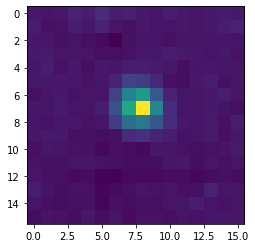

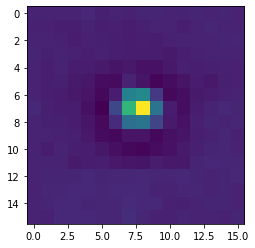

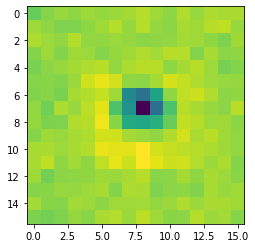

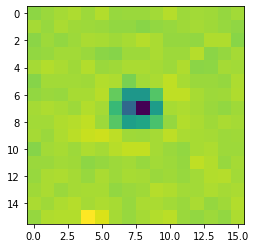

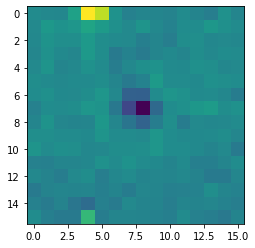

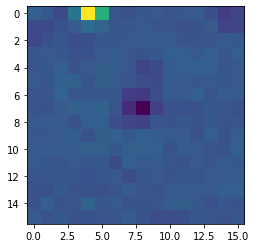

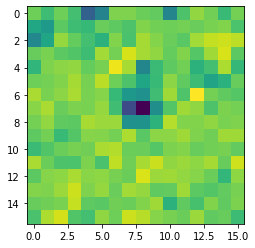

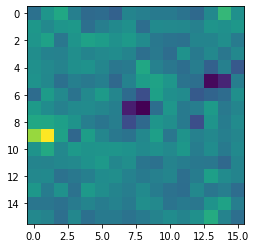

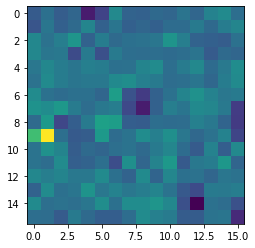

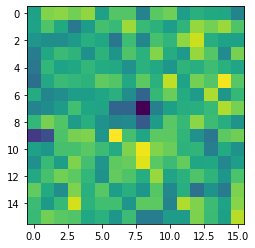

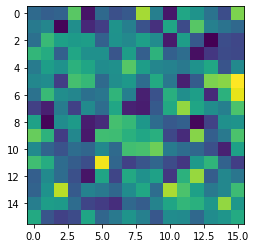

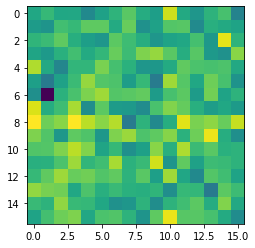

In [ ]:
class P3:
    def __init__(self):
        self.__TL = 0.0
        self.__TH = 10.0
    def __load_data(self, file_name='c2p3.mat'):
        loader = scipy.io.loadmat(file_name=file_name)
        self.__stim = loader['stim']
        self.__count = np.squeeze(loader['counts'])
        self.__x = self.__stim.shape[0]
        self.__y = self.__stim.shape[1]
        self.__total_steps = self.__stim.shape[2]
        # print(self.__stim.shape, self.__count.shape)
    def __comp_STA(self, max_steps):
        ret = np.zeros( (max_steps, self.__x, self.__y) )
        for iter in range(max_steps):
            ret[iter] = np.average(self.__stim[...,0:self.__total_steps-iter], 2, self.__count[iter:self.__total_steps])
            ret[iter] = ret[iter] / np.max(ret[iter])
        return ret
    def __plot(self, pic):
        for iter in pic:
            # print(iter.shape)
            x = np.arange(0, self.__x)
            y = np.arange(0, self.__y)
            # cv2_imshow(iter)
            plt.imshow(iter)
            plt.show()
    def __call__(self):
        self.__load_data()
        STA = self.__comp_STA(12)
        self.__plot(STA)


W3 = P3()
W3()

# Problem 4

For a Gaussian random variable \\(x\\) with zero mean and standard deviation, prove that

\\(\langle xF(\alpha x)\rangle = \alpha\sigma^2\langle F'(\alpha x)\rangle\\)

where \\(\alpha\\) is a constant, \\(F\\) is any function, \\(F'\\) is its derivative,

\\(\langle xF(\alpha x)\rangle = \int\ dx\ \frac{1}{\sqrt{2\pi}\sigma}\exp\left(-\frac{x^2}{2\sigma^2}\right)xF(\alpha x)\\)

and similarly for \\(\langle F'(\alpha x)\rangle\\). This is the basis of the identity 

\\(\frac{1}{\sigma_s^2T}\int_0^T\ dt\ F(L(t))s(t-\tau)=\frac{D(\tau)}{T}\int_0^T\ dt\ \frac{dF(L(t))}{DL}\\)

which can be derived by extending this basic result first to multivariate functions and then to functionals.

We have \\(F(x)=A(x)+B(x)\\), where \\(A(x)\\) is odd and \\(B(x)\\) is even, the rest part of the proof id trivial.

# Problem 5

Using the inverses of equations 2.15 and 2.17

\\(\epsilon=\epsilon_0(\exp(X/\lambda)-1)\\)
and
\\(a=-\frac{180(\epsilon_0+\epsilon)Y}{\lambda\epsilon\pi}\\)

map from cortical coordinates back to visual coordinates and determine what various patterns of activity across the primary visual cortex would “look like”. Ermentrout and Cowan (Ermentrout, GB, & Cowan, J (1979) A mathematical theory of visual hallucination patterns. Biological Cybernetics 34:137–150) used these results as a basis of a mathematical theory of visual hallucinations.

The figure generated by the matlab® program 2p5.m shows an illustrative example. This program simulates a plane sine wave of activity across the primary visual cortex with a specified spatial frequency and direction, and then maps it back into retinal coordinates to see what visual pattern would be perceived due to this activity. Consider various other patterns of activity and show the visual hallucinations they would generate.


The author has provided the matlab code



```
% mapping from cortex into the retina
lam=1.2   % constants for the map
ep0=1.0;

[X,Y]=meshgrid(0.05:.01:3,-2:.01:2);
             % global coordinates for the cortex

ep=ep0*(exp(X/lam)-1);              % eccentricity
a=-(180*(ep0+ep).*Y)./(lam*ep*pi);  % azimuth
in=abs(a)<90;                       
a=a.*(abs(a)<90)+90*(a>=90) - 90*(a<=-90);
                                    % take care of absurdities
clf;
K=8;
Theta=pi/6;
Phi=0;
s=cos(K*X*cos(Theta)+K*Y*sin(Theta)-Phi);
subplot(2,2,1);
imagesc(X(1,:),Y(:,1),s.*in);
set(gca,'fontsize',18,'fontname','palatino');
title('visual cortex');
xlabel('X (cm)');
ylabel('Y (cm)');
daspect([1 1.5 1]);
subplot(2,2,2);
contourf(ep.*cos(a*2*pi/360),ep.*sin(a*2*pi/360),s,'w:');
set(gca,'xlim',[0 12],'ylim',[-12 12]);
set(gca,'fontsize',18,'fontname','palatino');
title('visual space');
daspect([1 1 1]);
xlabel('degrees');
ylabel('degrees');

```

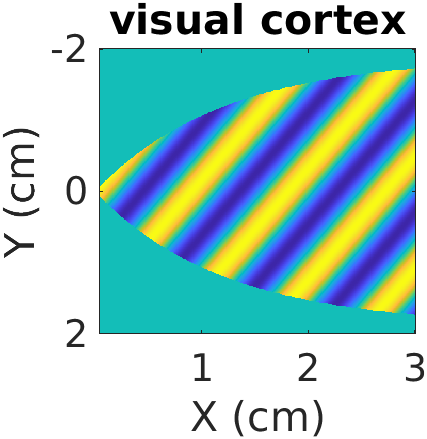

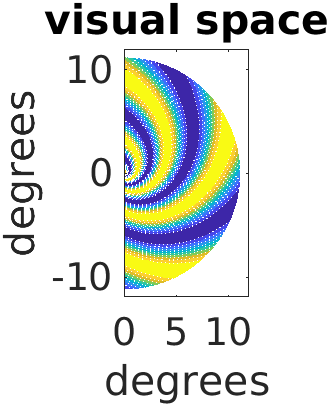

# Problem 6

Perform the integrals in equations 2.31 and 2.32 for the case 
\\(\sigma_x=\sigma_y=\sigma\\) to obtain the results

\\(L_s=\frac{A}{2}\exp\left(-\frac{\sigma^2(k^2+K^2)}{2}\right)(\cos(\phi-\Phi)\exp(\sigma^2kK\cos(\Theta))+\cos(\phi+\Phi)\exp(-\sigma^2kK\cos(\Theta)))\\)

and

\\(L_t(t)=\frac{\alpha^6|\omega|\sqrt{\omega^2+4\alpha^2}}{(\omega^2+\alpha^2)^4}\cos(\omega t-\delta)\\)

with

\\(\delta=8\arctan\left(\frac{\omega}{\alpha}\right)+\arctan\left(\frac{2\alpha}{\omega}\right)-\pi\\)

From these results, verify the selectivity curves in figures 2.15 and 2.16. In addition, plot \\(\delta\\) as a function of \\(\omega\\).


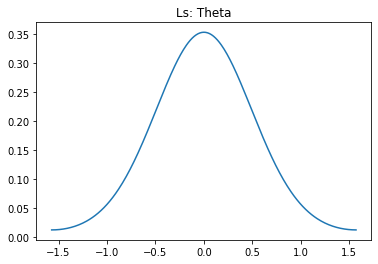

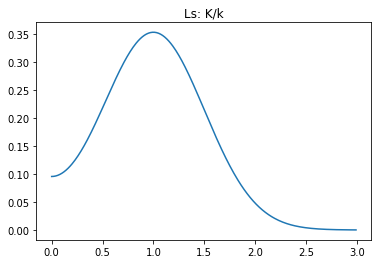

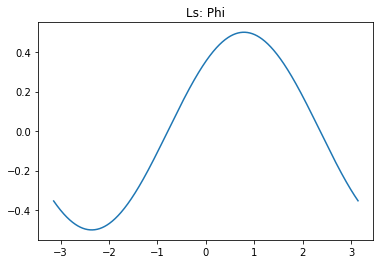

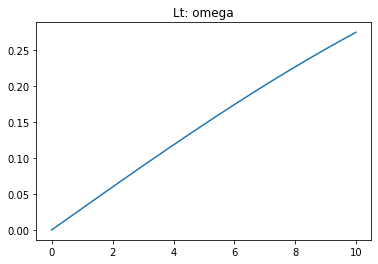

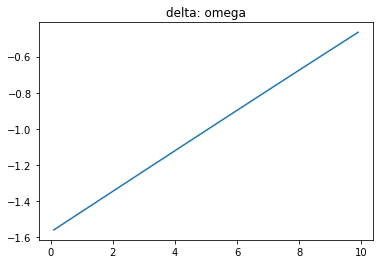

In [ ]:
class P6:
    class Ls(Func):
        def __init__(self, sigma=2.0, K=1.0, k=1.0, phi=pi/4, Phi=0.0, Theta=0.0):
            '''
            those default values appear in page 91
            '''
            super().__init__()
            self.__sigma = sigma
            self.__K = K
            self.__k = k
            self.__phi = phi
            self.__Phi = Phi
            self.__Theta = Theta
            self.__A = 1
        def __value(self, sigma, K, k, phi, Phi, Theta):
            return (0.5*self.__A*np.exp(-(sigma**2)*(k**2+K**2)/2)*(np.cos(phi-Phi)*np.exp((sigma**2)*k*K*np.cos(Theta))+np.cos(phi+Phi)*np.exp(-(sigma**2)*k*K*np.cos(Theta))))
        def __call__(self, sigma=None, K=None, k=None, phi=None, Phi=None, Theta=None):
            if isinstance(sigma, float)==False and isinstance(sigma, np.ndarray)==False:
                sigma = self.__sigma
            if isinstance(K, float)==False and isinstance(K, np.ndarray)==False:
                K = self.__K
            if isinstance(k, float)==False and isinstance(k, np.ndarray)==False:
                k = self.__k
            if isinstance(phi, float)==False and isinstance(phi, np.ndarray)==False:
                phi = self.__phi
            if isinstance(Phi, float)==False and isinstance(Phi, np.ndarray)==False:
                Phi = self.__Phi
            if isinstance(Theta, float)==False and isinstance(Theta, np.ndarray)==False:
                Theta = self.__Theta
            return self.__value(sigma, K, k, phi, Phi, Theta)
    class delta(Func):
        def __init__(self, alpha=1/0.015):
            self.__alpha = alpha
        def value(self, omega, alpha=None):
            if isinstance(alpha, float)==False and isinstance(alpha, np.ndarray)==False:
                alpha = self.__alpha
            return 8*np.arctan(omega/alpha) + np.arctan(2*alpha/omega) - pi
    class Lt(Func):
        def __init__(self, omega=1.0, alpha=1/0.015):
            '''
            alpha is 1/(15ms), in page 82
            '''
            self.__omega = omega
            self.__alpha = alpha
        def value(self, omega):
            # omega = self.__omega
            alpha = self.__alpha
            return (alpha**6*np.abs(omega)*np.sqrt(omega**2+4*alpha**2) / (omega**2+alpha**2)**4)
    def __init__(self):
        self.__Ls = self.Ls()
        self.__delta = self.delta()
        self.__Lt = self.Lt()
    def __plot(self, title='', x=None, y=None):
        plt.plot(x, y)
        plt.title(title)
        plt.show()
    def __process_Ls(self):
        Theta = np.arange(-pi/2, pi/2, 0.01)
        Ls0 = self.__Ls(Theta=Theta)
        self.__plot('Ls: Theta', Theta, Ls0)
        K = np.arange(0, 3, 0.01)
        Ls1 = self.__Ls(K=K)
        self.__plot('Ls: K/k', K, Ls1)
        Phi = np.arange(-pi, pi, 0.01)
        Ls2 = self.__Ls(Phi=Phi)
        self.__plot('Ls: Phi', Phi, Ls2)
    def __process_Lt(self):
        omega = np.arange(0, 10, 0.01)
        Lt = self.__Lt(omega)
        self.__plot('Lt: omega', omega, Lt)
    def __process_delta(self):
        omega = np.arange(0.1, 10, 0.1)
        delta = self.__delta(omega)
        self.__plot('delta: omega', omega, delta)
    def __process(self):
        self.__process_Ls()
        self.__process_Lt()
        self.__process_delta()
    def __call__(self):
        self.__process()

W6 = P6()
W6()

# Problem 7

Numerically compute the spatial part of the linear response of a simple cell with a separable space-time receptive field to a sinusoidal grating, as given by equation \\(L_s=\int\ dx\ dy\ D_s(x,y)Ax\cos(Kx\cos\Theta+Ky\sin\Theta-\Phi)\\).

Use a stimulus oriented with \\(\Theta=0\\). For the spatial receptive field kernel, use equation \\(D_s(x,y)=\frac{1}{\sigma_x\sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)\\) with \\(\sigma_x=\sigma_y=1^\circ, \phi=0\\), and \\(1/k=0.5^\circ\\). Plot \\(L_s\\) as a function of \\(K\\) taking \\(\Phi=0\\) and \\(A=50\\). This determines the spatial frequency selectivity of the cell. What is its preferred spatial frequency? Plot \\(L_s\\) as a function of \\(\Phi\\) taking \\(1/K=0.5^\circ\\) and \\(A=50\\). This determines the spatial phase selectivity of the cell. What is its preferred spatial phase?

The problem 6 has provided the algebra expression of \\(L_s\\), 


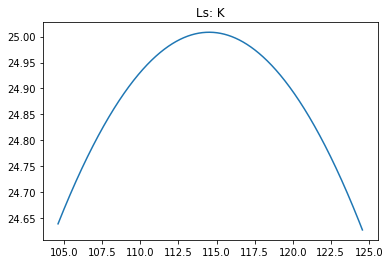

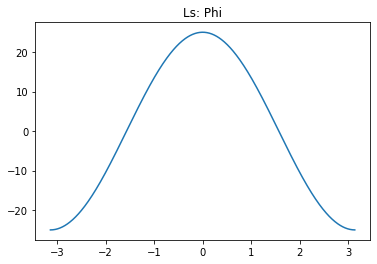

In [ ]:
class P7:
    class Ls(Func):
        def __init__(self, sigma=pi/180, K=360/pi, k=360/pi, phi=0.0, Phi=0.0, Theta=0.0):
            '''
            those default values appear in page 91
            '''
            super().__init__()
            self.__sigma = sigma
            self.__K = K
            self.__k = k
            self.__phi = phi
            self.__Phi = Phi
            self.__Theta = Theta
            self.__A = 50.0
        def __value(self, sigma, K, k, phi, Phi, Theta):
            return (0.5*self.__A*np.exp(-(sigma**2)*(k**2+K**2)/2)*(np.cos(phi-Phi)*np.exp((sigma**2)*k*K*np.cos(Theta))+np.cos(phi+Phi)*np.exp(-(sigma**2)*k*K*np.cos(Theta))))
        def __call__(self, sigma=None, K=None, k=None, phi=None, Phi=None, Theta=None):
            if isinstance(sigma, float)==False and isinstance(sigma, np.ndarray)==False:
                sigma = self.__sigma
            if isinstance(K, float)==False and isinstance(K, np.ndarray)==False:
                K = self.__K
            if isinstance(k, float)==False and isinstance(k, np.ndarray)==False:
                k = self.__k
            if isinstance(phi, float)==False and isinstance(phi, np.ndarray)==False:
                phi = self.__phi
            if isinstance(Phi, float)==False and isinstance(Phi, np.ndarray)==False:
                Phi = self.__Phi
            if isinstance(Theta, float)==False and isinstance(Theta, np.ndarray)==False:
                Theta = self.__Theta
            return self.__value(sigma, K, k, phi, Phi, Theta)
    def __init__(self):
        self.__Ls = self.Ls()
    def __plot(self, title='', x=None, y=None):
        plt.plot(x, y)
        plt.title(title)
        plt.show()
    def __process_Ls(self):
        K = np.arange(360/pi-10, 360/pi+10, 0.01)
        Ls0 = self.__Ls(K=K)
        self.__plot('Ls: K', K, Ls0)
        Phi = np.arange(-pi, pi, 0.01)
        Ls1 = self.__Ls(Phi=Phi)
        self.__plot('Ls: Phi', Phi, Ls1)
    def __process(self):
        self.__process_Ls()
    def __call__(self):
        self.__process()

W7 = P7()
W7()

# Problem 8

Consider a complex cell with the spatial part of its response given by \\(L^2_1+L^2_2\\), where \\(L_1\\) and \\(L_2\\) are linear responses determined by equation \\(L_s=\int\ dx\ dy\ D_s(x,y)Ax\cos(Kx\cos\Theta+Ky\sin\Theta-\Phi)\\) with kernels given by equation \\(D_s(x,y)=\frac{1}{\sigma_x\sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)\\) with \\(\sigma_x=\sigma_y=1^\circ\\), and \\(1/k=0.5^\circ\\); and with \\(\phi=0\\) for \\(L_1\\) and \\(-\pi/2\\) for \\(L_2\\) . Use a stimulus oriented with \\(\Theta=0\\).

Compute and plot \\(L^2_1+L^2_2\\) as a function of \\(K\\) taking \\(\Phi=0\\) and \\(A=5\\). This determines the spatial frequency selectivity of the cell. 

Compute and plot \\(L^2_1+L^2_2\\) as a function of \\(\Phi\\) taking \\(1/K=0.5^\circ\\) and \\(A=5\\). This determines the spatial phase selectivity of the cell. Does the spatial phase selectivity match what you expect for a complex cell?

In page 75, the the author stated the properties of complex cell. If we ignore the term \\(\cos(\phi-\Phi)\exp(-\sigma^2kK\cos\Theta)\\), the function \\(L^2_1+L^2_2\\) of \\(\Phi\\) will be a constant.

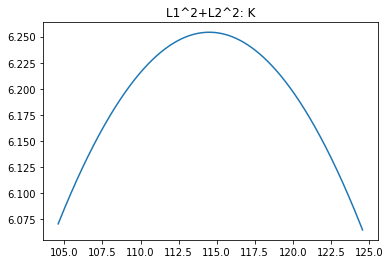

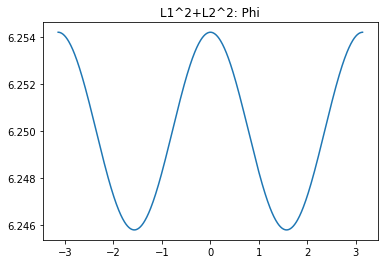

In [ ]:
class P8:
    class Ls(Func):
        def __init__(self, sigma=pi/180, K=360/pi, k=360/pi, phi=0.0, Phi=0.0, Theta=0.0):
            '''
            those default values appear in page 91
            '''
            super().__init__()
            self.__sigma = sigma
            self.__K = K
            self.__k = k
            self.__phi = phi
            self.__Phi = Phi
            self.__Theta = Theta
            self.__A = 5.0
        def __value(self, sigma, K, k, phi, Phi, Theta):
            return (
                0.5*self.__A*np.exp(-(sigma**2)*(k**2+K**2)/2) *# *np.ones(Phi.size)
                (np.cos(phi-Phi)*np.exp((sigma**2)*k*K*np.cos(Theta))+np.cos(phi+Phi)*np.exp(-(sigma**2)*k*K*np.cos(Theta)))
                )
        def __call__(self, sigma=None, K=None, k=None, phi=None, Phi=None, Theta=None):
            if isinstance(sigma, float)==False and isinstance(sigma, np.ndarray)==False:
                sigma = self.__sigma
            if isinstance(K, float)==False and isinstance(K, np.ndarray)==False:
                K = self.__K
            if isinstance(k, float)==False and isinstance(k, np.ndarray)==False:
                k = self.__k
            if isinstance(phi, float)==False and isinstance(phi, np.ndarray)==False:
                phi = self.__phi
            if isinstance(Phi, float)==False and isinstance(Phi, np.ndarray)==False:
                Phi = self.__Phi
            if isinstance(Theta, float)==False and isinstance(Theta, np.ndarray)==False:
                Theta = self.__Theta
            return self.__value(sigma, K, k, phi, Phi, Theta)
    def L(self, K=None, Phi=None):
        return self.__L1(K=K, Phi=Phi)**2 + self.__L2(K=K, Phi=Phi)**2
    def __init__(self):
        self.__L1 = self.Ls()
        self.__L2 = self.Ls(phi=-pi/2)
    def __plot(self, title='', x=None, y=None):
        plt.plot(x, y)
        plt.title(title)
        plt.show()
    def __process_Ls(self):
        K = np.arange(360/pi-10, 360/pi+10, 0.01, dtype=np.float128)
        Ls0 = self.L(K=K)
        self.__plot('L1^2+L2^2: K', K, Ls0)
        Phi = np.arange(-pi, pi, 0.01, dtype=np.float128)
        Ls1 = self.L(Phi=Phi)
        self.__plot('L1^2+L2^2: Phi', Phi, Ls1)
        # print(self.L(Phi=-pi), self.L(Phi=pi/4))
    def __process(self):
        self.__process_Ls()
    def __call__(self):
        self.__process()

W8 = P8()
W8()

# Problem 9

Consider the linear temporal response for a simple or complex cell given by equation \\(L_t(t)=\int_0^\infty\ d\tau\ D_t(\tau)\cos(\omega(t-\tau))\\) with a temporal kernel given by equation

\\(D_t(\tau)=\alpha\exp(-\alpha\tau)\left(\frac{(\alpha\tau)^5}{5!}-\frac{(\alpha\tau)^7}{7!}\right)\\)
 
with \\(1/\alpha=15\text{ms}\\).
 
Compute and plot \\(L_t(t)\\) for \\(\omega=6\pi/s\\). This determines the temporal response of the simple cell. Do not plot the negative part of \\(L_t(t)\\) because the cell cannot fire at a negative rate.

Compute and plot \\(L^2_t(t)\\) for \\(\omega=6\pi/s\\). This determines the temporal response of a complex cell. What are the differences between the temporal responses of the simple and complex cells?

The coding is trivial, we omit it, the transform in a simple cell is linear, while in a complex cell it is not.

# Problem 10

Compute the response of a model simple cell with a separable space-time receptive field to a moving grating

\\(s(x,y,t)=\cos(Kx-\omega t)\\)

for \\(D_s\\), use equation \\(D_s(x,y)=\frac{1}{\sigma_x\sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)\\) with \\(\sigma_x=\sigma_y=1^\circ\\), and \\(1/k=0.5^\circ\\).

For \\(D_t\\), use equation \\(D_t(\tau)=\alpha\exp(-\alpha\tau)\left(\frac{(\alpha\tau)^5}{5!}-\frac{(\alpha\tau)^7}{7!}\right)\\) with \\(1/\alpha=15\text{ms}\\).

Compute the linear estimate of the response given by equation 2.24 and assume that the actual response is proportional to a rectified version of this linear response estimate.

Plot the response as a function of time for \\(1/K=1/k=0.5^\circ\\) and \\(\omega=8\pi/s\\).

Plot the response amplitude as a function of \\(\omega\\) for
\\(1/K=1/k=0.5^\circ\\) and as a function of \\(K\\) for \\(\omega=8\pi/s\\).

The coding is trivial, we omit it.


# Problem 11

Compute the response of a model complex cell to the moving grating

\\(s(x,y,t)=\cos(Kx-\omega t)\\)

The complex cell should be modeled by squaring the unrectified
linear response estimate of a simple cells with a spatial receptive
field given by equation

\\(D_s(x,y)=\frac{1}{\sigma_x\sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)\\)

with \\(\sigma_x=\sigma_y=1^\circ, \phi=0\\), and \\(1/k=0.5^\circ\\), and adding this to the square of the unrectified linear response of a second simple cell with identical properties except that its spatial phase preference is \\(\phi=-\pi/2\\) instead of \\(\phi=0\\).

Both linear responses are computed from equation

\\(L(t)=\int_0^\infty\ d\tau\int\ dx\ dy\ D(x,y,\tau)s(x,y,t-\tau)\\).

For both of these, use equation with \\(D_t(\tau)=\alpha\exp(-\alpha\tau)\left(\frac{(\alpha\tau)^5}{5!}-\frac{(\alpha\tau)^7}{7!}\right)\\) with \\(1/\alpha=15\text{ms}\\) for the temporal receptive field. Plot the complex
cell response as a function of time for \\(1/K=1/k=0.5^\circ\\) and \\(\omega=8\pi/s\\).

Plot the response amplitude as a function of \\(\omega\\) for \\(1/K=1/k=0.5^\circ\\) and as a function of \\(K\\) for \\(\omega=8\pi/s\\).

The rest problems have the similar solution, we omit them.

I am not pretty sure about the result.

(80, 100) (80, 100, 2000)


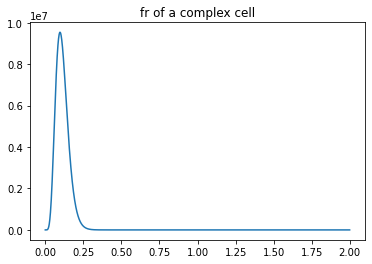

In [42]:
class P11:
    class Stimulus(Func):
        def __init__(self, K=360.0/pi, omega=8*pi):
            super().__init__()
            self.__K = K
            self.__omega = omega
        def value(self, x=0.0, y=0.0, t=0.0):
            x = np.asarray(x)
            y = np.asarray(y)
            t = np.asarray(t)
            ret = np.zeros((x.size, y.size, t.size))
            for (ind_x, val_x) in enumerate(x):
                ret[ind_x] = np.swapaxes(np.full((t.size, y.size), np.cos(self.__K*val_x-self.__omega*t)), 0, 1)
            if t.size == 1:
                ret = np.squeeze(ret, 2)
            return ret
        def __call__(self, x=0.0, y=0.0, t=0.0):
            return self.value(x, y, t)
    class Spatial_Kernel(Func):
        def __init__(self, sigma=pi/180.0, k=360.0/pi, phi=0.0):
            super().__init__()
            self.__sigma = sigma
            self.__k = k
            self.__phi = phi
        def value(self, x, y):
            sigma = self.__sigma
            k = self.__k
            phi = self.__phi
            sx = x.size
            sy = y.size
            x = np.repeat(np.expand_dims(x, 1), sy, 1)
            y = np.repeat(np.expand_dims(y, 0), sx, 0)
            # print(x, y)
            return 1/(sigma**2) * np.exp(-(x**2+y**2)/(2*sigma**2)) * np.cos(k*x-phi)
        def __call__(self, x, y):
            return self.value(x, y)
    class Temporal_Kernel(Func):
        def __init__(self, alpha=1/ms2s(15)):
            super().__init__()
            self.__alpha = alpha
        def value(self, tau):
            alpha = self.__alpha
            # print(np.exp(-alpha*tau), '*', (alpha*tau)**5/120-(alpha*tau)**7/5040, '=', np.exp(-alpha*tau)*((alpha*tau)**5/120-(alpha*tau)**7/5040))
            return alpha*np.exp(-alpha*tau)*((alpha*tau)**5/120-(alpha*tau)**7/5040)
    def response(self, x, y, t, s, Ds, Dt):
        ret = np.zeros(t.size)
        spatial_kernel = Ds(x, y)
        stim = np.zeros((x.size, y.size, t.size))
        print(spatial_kernel.shape, stim.shape)
        for iter in range(t.size):
            stim[..., iter] = s(x, y, iter)
        for iter in range(t.size):
            for tau in range(min(iter+1, 2000)):
                ret[iter] = ret[iter] + np.sum(spatial_kernel*Dt(tau*0.001)*stim[..., iter-tau])
            # print(iter, ret[iter])
        return ret
    def __process(self):
        x = np.arange(-0.4, 0.4, 0.01)
        y = np.arange(-0.5, 0.5, 0.01)
        t = np.arange(0, 2, 0.001)
        s = self.Stimulus()
        Ds = self.Spatial_Kernel()
        Dt = self.Temporal_Kernel()
        # tt = np.arange(0.0, 1, 0.001)
        # dt = Dt(tt)
        # self.__plot(tt, dt)
        return (t, self.response(x, y, t, s, Ds, Dt))
    def __plot(self, t, r):
        plt.plot(t, r)
        plt.title('fr of a complex cell')
        plt.show()
    def __call__(self):
        t, r = self.__process()
        self.__plot(t, r)

W11 = P11()
W11()


# Problem 12
Construct a model simple cell with the nonseparable space-time receptive field described in the caption of figure 2.21B. Compute its response to the moving grating

\\(s(x,y,t)=\cos(Kx-\omega t)\\)

Plot the amplitude of the response as a function of the velocity of the
grating, \\(\omega/K\\), using \\(\omega=8\pi/s\\) and varying \\(K\\) to obtain a range of both positive and negative velocity values (use negative \\(K\\) values for this). Show that the response is directionally selective.



# Problem 13

Construct a model complex cell that is disparity tuned but insensitive to the absolute position of a grating.

The complex cell is constructed by summing the squares of the unrectified linear responses of two simple cells, but disparity e ects are now included. For this exercise, we ignore temporal factors and only consider the spatial dependence of the response.

Each simple cell response is composed of two terms that correspond to inputs coming from the left and right eyes. Because of disparity, the spatial phases of the image of a grating in the two eyes, \\(\Phi_L\\) and \\(\Phi_R\\), may be different.

We write the spatial part of the linear response estimate for a grating with the preferred spatial frequency \\((k=K)\\)nd orientation \\((\Theta=\theta=0)\\) as

\\(L_1=\frac{A}{2}(\cos(\Phi_L)+\cos(\Phi_k))\\)

assuming that \\(\phi=0\\) (this equation is a generalization of equation 
\\(L_s=\frac{A}{2}\exp\left(-\frac{\sigma^2(k-K)^2}{2}\right)\cos(\phi-\Phi)\\)).

Let the complex cell response be proportional to \\(L^2_1+L^2_2\\), where \\(L_2\\) is similar to \\(L_1\\) but with the cosine functions replaced by
sine functions. Show that the response of this neuron is tuned to the disparity, \\(\Phi_L-\Phi_R\\), but is independent of the absolute spatial phase of the grating,  \\(\Phi_L+\Phi_R\\). Plot the response tuning curve as a function of disparity. (See DeAngelis, GC, Ohzawa, I, & Freeman, RD (1991) Depth is encoded in the visual cortex by a specialized receptive field structure. Nature 352:156–159.)



# Problem14

Determine the selectivity of the LGN receptive field of equation

\\(D_s(x,y)=\pm\left(\frac{1}{2\pi\sigma_\text{cen}^2}\exp\left(-\frac{x^2+y^2}{2\sigma_\text{cen}}\right)-\frac{B}{2\pi\sigma_\text{sur}^2}\exp\left(-\frac{x^2+y^2}{2\sigma_\text{sur}}\right)\right)\\)

to spatial frequency by computing its integrals when multiplied by the stimulus

\\(s=\cos(Kx)\\)

for a range of K values. Use \\(\sigma_c=03^\circ,\sigma_s=1.5^\circ,B=5,1/\alpha=16\text{ms}\\), and \\(1/\beta=64\text{ms}\\), and plot the resulting spatial frequency tuning curve.



# Problem 15

Construct the Hubel-Wiesel model of a simple-cell spatial receptive field, as depicted in figure 2.27A.

Use difference-of-Gaussian functions (equation \\(D_s(x,y)=\pm\left(\frac{1}{2\pi\sigma_\text{cen}^2}\exp\left(-\frac{x^2+y^2}{2\sigma_\text{cen}}\right)-\frac{B}{2\pi\sigma_\text{sur}^2}\exp\left(-\frac{x^2+y^2}{2\sigma_\text{sur}}\right)\right)\\)) to model the LGN receptive fields. Plot the spatial receptive field of the simple cell constructed by summing the spatial receptive fields of the LGN cells that provide its input.

Compare the result of summing appropriately placed LGN center-surround receptive fields (figure 2.27A) with the results of an appropriately adjusted Gabor filter model of the simple cell that uses the spatial kernel of equation \\(D_s(x,y)=\frac{1}{\sigma_x\sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)\\).


# Problem 16

Construct the Hubel-Wiesel model of a complex cell, as depicted in figure 2.27B. Use Gabor functions (equation \\(D_s(x,y)=\frac{1}{\sigma_x\sigma_y}\exp\left(-\frac{x^2}{2\sigma_x^2}-\frac{y^2}{2\sigma_y^2}\right)\cos(kx-\phi)\\)) to model the simple cell responses, which should be rectified before being summed. Plot the spatial receptive field of the complex cell constructed by summing the different simple cell responses. Compare the responses of a complex cell constructed by linearly summing the outputs of simple cells (figure 2.27B) with different spatial phase preferences with the complex cell model obtained by squaring and summing two unrectified simple cell responses with spatial phases 90Æ apart as in exercise 8.
